In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
# Load the Excel file
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse('Electricity kWh')
weather_df = xls.parse('Weather archive')

# Clean electricity data
new_header = electricity_df.iloc[0]
electricity_df_clean = electricity_df[1:].copy()
electricity_df_clean.columns = new_header
electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
electricity_df_clean["Timestamp"] = pd.to_datetime(electricity_df_clean["Timestamp"])
electricity_df_clean.set_index("Timestamp", inplace=True)
electricity_df_clean = electricity_df_clean.apply(pd.to_numeric, errors='coerce')
electricity_df_clean = electricity_df_clean.groupby(electricity_df_clean.index).mean()
electricity_df_clean["Total_kWh"] = electricity_df_clean.sum(axis=1)

# Clean weather data
weather_df.columns = weather_df.iloc[1]
weather_df_clean = weather_df[2:].copy()
weather_df_clean.rename(columns={"Local time in Tallinn ": "Timestamp"}, inplace=True)
weather_df_clean["Timestamp"] = pd.to_datetime(weather_df_clean["Timestamp"], dayfirst=True, errors='coerce')

# Rename relevant columns for clarity
weather_df_clean.rename(columns={
    "T": "Temperature (°C)",
    "P0": "Pressure (mmHg)",
    "U": "Humidity (%)",
    "Ff": "Wind speed (m/s)"
}, inplace=True)

# Define numeric columns
numeric_cols = ["Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]

# Coerce non-numeric values to NaN
for col in numeric_cols:
    weather_df_clean[col] = pd.to_numeric(weather_df_clean[col], errors='coerce')

# Drop rows with invalid timestamps or all NaN numeric values
weather_df_clean.dropna(subset=["Timestamp"] + numeric_cols, how="all", inplace=True)

# Ensure only numeric columns are included for resampling
weather_df_clean = weather_df_clean[["Timestamp"] + numeric_cols]

# Set the timestamp as the index and resample to hourly frequency
weather_df_clean = weather_df_clean.set_index("Timestamp").resample("h").mean()
# Merge datasets
combined_df = electricity_df_clean.merge(weather_df_clean, left_index=True, right_index=True, how='inner')
print(combined_df.columns)
# Filter data for a specific building
building_id = "OBS"  # Replace with the desired building's identifier
building_data = combined_df[[building_id, "Total_kWh", "Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]] # Adjust column name if needed

# Use the filtered data for further processing
data_2023 = building_data.loc['2023']  # Filter data for the year 2023
data_2023 = combined_df.loc['2023']

Index(['ICT', 'U06, U06A, U05B', 'OBS', 'U05, U04, U04B, GEO', 'TEG', 'LIB',
       'MEK', 'SOC', 'S01', 'D04', 'Total_kWh', 'Temperature (°C)',
       'Pressure (mmHg)', 'Wind speed (m/s)'],
      dtype='object')


C:\Users\tavim\AppData\Local\Temp\ipykernel_10124\1434856704.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)


In [24]:
# Prepare train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()
for month in range(1, 13):
    month_data = data_2023[data_2023.index.month == month]
    if len(month_data) < 4 * 7 * 24:
        continue
    start_idx = np.random.randint(0, len(month_data) - 2 * 7 * 24)
    train_weeks = month_data.iloc[start_idx:start_idx + 2 * 7 * 24]
    test_weeks = month_data.drop(train_weeks.index)
    train_data = pd.concat([train_data, train_weeks])
    test_data = pd.concat([test_data, test_weeks])
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Normalize data
scaler = StandardScaler()
train_data["Total_kWh"] = scaler.fit_transform(train_data[["Total_kWh"]])
test_data["Total_kWh"] = scaler.transform(test_data[["Total_kWh"]])

# Create sequences
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len].values)
        y.append(data[i+seq_len:i+seq_len+pred_len].values)
    return np.array(X), np.array(y)

seq_len = 168
pred_len = 24
X_train, y_train = create_sequences(train_data["Total_kWh"], seq_len, pred_len)
X_test, y_test = create_sequences(test_data["Total_kWh"], seq_len, pred_len)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [25]:
# Import TimesNet
import sys
sys.path.append(r"E:/Facultate/fewshot-ts-embedding/fewshot-ts-embedding")
from libs.timeserieslibrary.models.TimesNet import Model

# Define the TimesNet model
class Configs:
    task_name = 'long_term_forecast'  # Task type (e.g., 'long_term_forecast', 'short_term_forecast')
    seq_len = 168  # Input sequence length (e.g., 7 days of hourly data)
    label_len = 24  # Label length (context length for decoder, if applicable)
    pred_len = 24  # Prediction length (e.g., 1 day of hourly data)
    enc_in = 1  # Number of input features (e.g., electricity consumption)
    dec_in = 1  # Number of decoder input features
    c_out = 1  # Number of output features (e.g., electricity consumption)
    d_model = 64  # Model dimension
    e_layers = 2  # Number of encoder layers
    d_ff = 256  # Feedforward network dimension
    dropout = 0.1  # Dropout rate
    embed = "timeF"  # Embedding type (e.g., time features)
    freq = "h"  # Frequency of the data (e.g., hourly)
    top_k = 5  # Number of top periods for FFT
    num_kernels = 6  # Number of kernels for Inception blocks

configs = Configs()
model = Model(configs)
model = model.to(device)

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Load the Excel file
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse('Electricity kWh')
weather_df = xls.parse('Weather archive')

# Clean electricity data
new_header = electricity_df.iloc[0]
electricity_df_clean = electricity_df[1:].copy()
electricity_df_clean.columns = new_header
electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)
electricity_df_clean["Timestamp"] = pd.to_datetime(electricity_df_clean["Timestamp"])
electricity_df_clean.set_index("Timestamp", inplace=True)
electricity_df_clean = electricity_df_clean.apply(pd.to_numeric, errors='coerce')
electricity_df_clean = electricity_df_clean.groupby(electricity_df_clean.index).mean()
electricity_df_clean["Total_kWh"] = electricity_df_clean.sum(axis=1)

# Clean weather data
weather_df.columns = weather_df.iloc[1]
weather_df_clean = weather_df[2:].copy()
weather_df_clean.rename(columns={"Local time in Tallinn ": "Timestamp"}, inplace=True)
weather_df_clean["Timestamp"] = pd.to_datetime(weather_df_clean["Timestamp"], dayfirst=True, errors='coerce')

# Rename relevant columns for clarity
weather_df_clean.rename(columns={
    "T": "Temperature (°C)",
    "P0": "Pressure (mmHg)",
    "U": "Humidity (%)",
    "Ff": "Wind speed (m/s)"
}, inplace=True)

# Define numeric columns
numeric_cols = ["Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]

# Coerce non-numeric values to NaN
for col in numeric_cols:
    weather_df_clean[col] = pd.to_numeric(weather_df_clean[col], errors='coerce')

# Drop rows with invalid timestamps or all NaN numeric values
weather_df_clean.dropna(subset=["Timestamp"] + numeric_cols, how="all", inplace=True)

# Ensure only numeric columns are included for resampling
weather_df_clean = weather_df_clean[["Timestamp"] + numeric_cols]

# Set the timestamp as the index and resample to hourly frequency
weather_df_clean = weather_df_clean.set_index("Timestamp").resample("h").mean()

# Merge datasets
combined_df = electricity_df_clean.merge(weather_df_clean, left_index=True, right_index=True, how='inner')

# Filter data for a specific building
building_id = "OBS"  # Replace with the desired building's identifier
building_data = combined_df[[building_id, "Total_kWh", "Temperature (°C)", "Pressure (mmHg)", "Wind speed (m/s)"]]

# Use the filtered data for further processing
data_2023 = building_data.loc['2023']  # Filter data for the year 2023

# Randomly select 2 months for training
all_months = list(range(1, 13))
train_months = random.sample(all_months, 2)
test_months = [month for month in all_months if month not in train_months]

print(f"Training Months: {train_months}")
print(f"Testing Months: {test_months}")

# Prepare train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Add data for the selected training months
for month in train_months:
    month_data = data_2023[data_2023.index.month == month]
    train_data = pd.concat([train_data, month_data])

# Add data for the remaining testing months
for month in test_months:
    month_data = data_2023[data_2023.index.month == month]
    test_data = pd.concat([test_data, month_data])

# Sort the data by index
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

# Normalize data
scaler = StandardScaler()
train_data["Total_kWh"] = scaler.fit_transform(train_data[["Total_kWh"]])
test_data["Total_kWh"] = scaler.transform(test_data[["Total_kWh"]])

# Create sequences
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len].values)
        y.append(data[i+seq_len:i+seq_len+pred_len].values)
    return np.array(X), np.array(y)

seq_len = 168
pred_len = 24
X_train, y_train = create_sequences(train_data["Total_kWh"], seq_len, pred_len)
X_test, y_test = create_sequences(test_data["Total_kWh"], seq_len, pred_len)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")

# Import TimesNet
import sys
sys.path.append(r"E:/Facultate/fewshot-ts-embedding/fewshot-ts-embedding")
from libs.timeserieslibrary.models.TimesNet import Model
from libs.timeserieslibrary.layers.Conv_Blocks import Inception_Block_V1
from libs.timeserieslibrary.layers.Embed import DataEmbedding

# Define the TimesNet model
class Configs:
    task_name = 'long_term_forecast'
    seq_len = 168
    label_len = 24
    pred_len = 24
    enc_in = 1
    dec_in = 1
    c_out = 1
    d_model = 64
    e_layers = 2
    d_ff = 256
    dropout = 0.1
    embed = "timeF"
    freq = "h"
    top_k = 3
    num_kernels = 6

configs = Configs()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model(configs).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def create_time_features(index):
    """
    Create time-related features based on the index (timestamps).
    """
    time_features = pd.DataFrame(index=index)
    time_features['hour'] = index.hour
    time_features['day'] = index.day
    time_features['weekday'] = index.weekday
    time_features['month'] = index.month
    return torch.tensor(time_features.values, dtype=torch.float32)



C:\Users\tavim\AppData\Local\Temp\ipykernel_10124\2716230662.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  electricity_df_clean.rename(columns={new_header[0]: "Timestamp"}, inplace=True)


Training Months: [10, 7]
Testing Months: [1, 2, 3, 4, 5, 6, 8, 9, 11, 12]
Training Data Shape: torch.Size([1296, 168]), torch.Size([1296, 24])
Testing Data Shape: torch.Size([7078, 168]), torch.Size([7078, 24])


Pretraining Buildings: ['LIB', 'SOC', 'U06, U06A, U05B', 'S01', 'D04', 'OBS', 'MEK', 'ICT']
Fine-Tuning/Test Buildings: ['U05, U04, U04B, GEO', 'TEG']
Fine-Tuning Months: [6, 5]
Testing Months: [1, 2, 3, 4, 7, 8, 9, 10, 11, 12]


C:\Users\tavim\AppData\Local\Temp\ipykernel_10124\3892960750.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrain_data["Total_kWh"] = scaler.fit_transform(pretrain_data[["Total_kWh"]])


Pretraining Data Shape: torch.Size([8566, 168]), torch.Size([8566, 24])
Fine-Tuning Data Shape: torch.Size([1272, 168]), torch.Size([1272, 24])
Testing Data Shape: torch.Size([7102, 168]), torch.Size([7102, 24])


Pretraining Epoch 1/20:   0%|          | 0/268 [00:00<?, ?batch/s]C:\Users\tavim\AppData\Local\Temp\ipykernel_10124\3892960750.py:120: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  epoch_loss += loss.item()
Pretraining Epoch 1/20: 100%|██████████| 268/268 [02:14<00:00,  1.99batch/s, loss=0.0505]


Pretraining Epoch 1/20, Loss: 0.1741


Pretraining Epoch 2/20: 100%|██████████| 268/268 [02:20<00:00,  1.91batch/s, loss=0.047] 


Pretraining Epoch 2/20, Loss: 0.0775


Pretraining Epoch 3/20: 100%|██████████| 268/268 [02:19<00:00,  1.92batch/s, loss=0.16]  


Pretraining Epoch 3/20, Loss: 0.0667


Pretraining Epoch 4/20: 100%|██████████| 268/268 [02:24<00:00,  1.85batch/s, loss=0.0808]


Pretraining Epoch 4/20, Loss: 0.0602


Pretraining Epoch 5/20: 100%|██████████| 268/268 [02:22<00:00,  1.88batch/s, loss=0.0454]


Pretraining Epoch 5/20, Loss: 0.0551


Pretraining Epoch 6/20: 100%|██████████| 268/268 [02:21<00:00,  1.89batch/s, loss=0.0349]


Pretraining Epoch 6/20, Loss: 0.0523


Pretraining Epoch 7/20: 100%|██████████| 268/268 [02:21<00:00,  1.89batch/s, loss=0.0209]


Pretraining Epoch 7/20, Loss: 0.0508


Pretraining Epoch 8/20: 100%|██████████| 268/268 [02:22<00:00,  1.88batch/s, loss=0.0611]


Pretraining Epoch 8/20, Loss: 0.0483


Pretraining Epoch 9/20: 100%|██████████| 268/268 [02:22<00:00,  1.88batch/s, loss=0.0417]


Pretraining Epoch 9/20, Loss: 0.0480


Pretraining Epoch 10/20: 100%|██████████| 268/268 [02:23<00:00,  1.87batch/s, loss=0.0171]


Pretraining Epoch 10/20, Loss: 0.0457


Pretraining Epoch 11/20: 100%|██████████| 268/268 [02:23<00:00,  1.87batch/s, loss=0.0307]


Pretraining Epoch 11/20, Loss: 0.0448


Pretraining Epoch 12/20: 100%|██████████| 268/268 [02:25<00:00,  1.84batch/s, loss=0.0318]


Pretraining Epoch 12/20, Loss: 0.0459


Pretraining Epoch 13/20: 100%|██████████| 268/268 [02:22<00:00,  1.88batch/s, loss=0.0289]


Pretraining Epoch 13/20, Loss: 0.0417


Pretraining Epoch 14/20: 100%|██████████| 268/268 [02:23<00:00,  1.87batch/s, loss=0.042] 


Pretraining Epoch 14/20, Loss: 0.0431


Pretraining Epoch 15/20: 100%|██████████| 268/268 [02:22<00:00,  1.88batch/s, loss=0.0222]


Pretraining Epoch 15/20, Loss: 0.0415


Pretraining Epoch 16/20: 100%|██████████| 268/268 [02:18<00:00,  1.94batch/s, loss=0.0224]


Pretraining Epoch 16/20, Loss: 0.0407


Pretraining Epoch 17/20: 100%|██████████| 268/268 [02:17<00:00,  1.94batch/s, loss=0.0327]


Pretraining Epoch 17/20, Loss: 0.0404


Pretraining Epoch 18/20: 100%|██████████| 268/268 [02:17<00:00,  1.95batch/s, loss=0.0311]


Pretraining Epoch 18/20, Loss: 0.0391


Pretraining Epoch 19/20: 100%|██████████| 268/268 [02:17<00:00,  1.96batch/s, loss=0.0677]


Pretraining Epoch 19/20, Loss: 0.0379


Pretraining Epoch 20/20: 100%|██████████| 268/268 [02:16<00:00,  1.96batch/s, loss=0.0284]


Pretraining Epoch 20/20, Loss: 0.0351


Fine-Tuning Epoch 1/20: 100%|██████████| 40/40 [00:20<00:00,  1.96batch/s, loss=0.13]  


Fine-Tuning Epoch 1/20, Loss: 0.1211


Fine-Tuning Epoch 2/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0841]


Fine-Tuning Epoch 2/20, Loss: 0.0961


Fine-Tuning Epoch 3/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.084] 


Fine-Tuning Epoch 3/20, Loss: 0.1127


Fine-Tuning Epoch 4/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.101] 


Fine-Tuning Epoch 4/20, Loss: 0.0721


Fine-Tuning Epoch 5/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0512]


Fine-Tuning Epoch 5/20, Loss: 0.0710


Fine-Tuning Epoch 6/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.033] 


Fine-Tuning Epoch 6/20, Loss: 0.0679


Fine-Tuning Epoch 7/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0556]


Fine-Tuning Epoch 7/20, Loss: 0.0495


Fine-Tuning Epoch 8/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0412]


Fine-Tuning Epoch 8/20, Loss: 0.0475


Fine-Tuning Epoch 9/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0566]


Fine-Tuning Epoch 9/20, Loss: 0.0484


Fine-Tuning Epoch 10/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0299]


Fine-Tuning Epoch 10/20, Loss: 0.0659


Fine-Tuning Epoch 11/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0268]


Fine-Tuning Epoch 11/20, Loss: 0.0478


Fine-Tuning Epoch 12/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0455]


Fine-Tuning Epoch 12/20, Loss: 0.0352


Fine-Tuning Epoch 13/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0434]


Fine-Tuning Epoch 13/20, Loss: 0.0328


Fine-Tuning Epoch 14/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0369]


Fine-Tuning Epoch 14/20, Loss: 0.0501


Fine-Tuning Epoch 15/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0306]


Fine-Tuning Epoch 15/20, Loss: 0.0397


Fine-Tuning Epoch 16/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0327]


Fine-Tuning Epoch 16/20, Loss: 0.0419


Fine-Tuning Epoch 17/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0246]


Fine-Tuning Epoch 17/20, Loss: 0.0291


Fine-Tuning Epoch 18/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0353]


Fine-Tuning Epoch 18/20, Loss: 0.0310


Fine-Tuning Epoch 19/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0213]


Fine-Tuning Epoch 19/20, Loss: 0.0248


Fine-Tuning Epoch 20/20: 100%|██████████| 40/40 [00:20<00:00,  1.97batch/s, loss=0.0202]


Fine-Tuning Epoch 20/20, Loss: 0.0292
Test MAPE: 0.05%


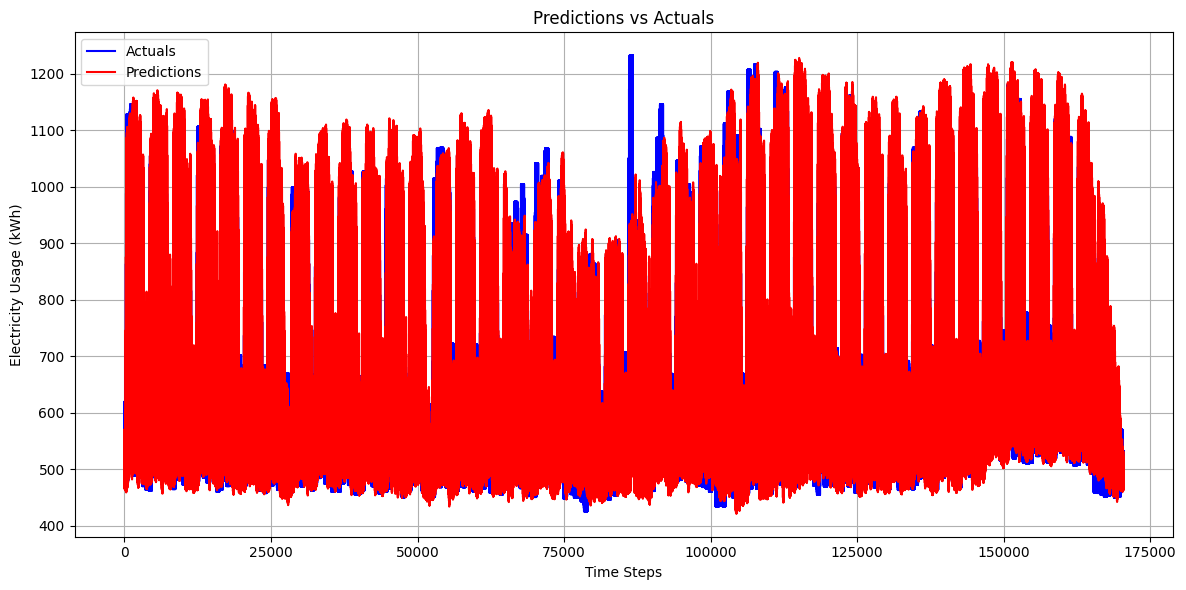

In [30]:
import random

# Step 1: Split buildings into pretraining and fine-tuning/testing groups
all_buildings = list(electricity_df_clean.columns)  # Get all building names
all_buildings.remove("Total_kWh")  # Exclude the "Total_kWh" column
random.shuffle(all_buildings)

# Use N-2 buildings for pretraining
pretrain_buildings = all_buildings[:-2]

# Use the remaining 2 buildings for fine-tuning and testing
finetune_test_buildings = all_buildings[-2:]

print(f"Pretraining Buildings: {pretrain_buildings}")
print(f"Fine-Tuning/Test Buildings: {finetune_test_buildings}")

# Step 2: Prepare pretraining data
pretrain_data = combined_df[pretrain_buildings + ["Total_kWh"]]

# Step 3: Prepare fine-tuning and testing data
finetune_test_data = combined_df[finetune_test_buildings + ["Total_kWh"]]

# Randomly select 2 months for fine-tuning
all_months = list(range(1, 13))
finetune_months = random.sample(all_months, 2)
test_months = [month for month in all_months if month not in finetune_months]

print(f"Fine-Tuning Months: {finetune_months}")
print(f"Testing Months: {test_months}")

# Fine-tuning data
finetune_data = pd.DataFrame()
for month in finetune_months:
    month_data = finetune_test_data[finetune_test_data.index.month == month]
    finetune_data = pd.concat([finetune_data, month_data])

# Testing data
test_data = pd.DataFrame()
for month in test_months:
    month_data = finetune_test_data[finetune_test_data.index.month == month]
    test_data = pd.concat([test_data, month_data])

# Step 4: Normalize data
scaler = StandardScaler()

# Pretraining data normalization
pretrain_data["Total_kWh"] = scaler.fit_transform(pretrain_data[["Total_kWh"]])

# Fine-tuning and testing data normalization
finetune_data["Total_kWh"] = scaler.transform(finetune_data[["Total_kWh"]])
test_data["Total_kWh"] = scaler.transform(test_data[["Total_kWh"]])

# Step 5: Create sequences
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len].values)
        y.append(data[i+seq_len:i+seq_len+pred_len].values)
    return np.array(X), np.array(y)

seq_len = 168
pred_len = 24

# Pretraining sequences
X_pretrain, y_pretrain = create_sequences(pretrain_data["Total_kWh"], seq_len, pred_len)

# Fine-tuning sequences
X_finetune, y_finetune = create_sequences(finetune_data["Total_kWh"], seq_len, pred_len)

# Testing sequences
X_test, y_test = create_sequences(test_data["Total_kWh"], seq_len, pred_len)

# Convert to tensors
X_pretrain = torch.tensor(X_pretrain, dtype=torch.float32)
y_pretrain = torch.tensor(y_pretrain, dtype=torch.float32)
X_finetune = torch.tensor(X_finetune, dtype=torch.float32)
y_finetune = torch.tensor(y_finetune, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Pretraining Data Shape: {X_pretrain.shape}, {y_pretrain.shape}")
print(f"Fine-Tuning Data Shape: {X_finetune.shape}, {y_finetune.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")

# Step 6: Pretraining
pretrain_loader = DataLoader(torch.utils.data.TensorDataset(X_pretrain, y_pretrain), batch_size=32, shuffle=True)
finetune_loader = DataLoader(torch.utils.data.TensorDataset(X_finetune, y_finetune), batch_size=32, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

# Training loop
# Training loop with time-related features
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    with tqdm(pretrain_loader, desc=f"Pretraining Epoch {epoch+1}/{epochs}", unit="batch") as t:
        for batch_X, batch_y in t:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Add a singleton dimension for the feature axis
            batch_X = batch_X.unsqueeze(-1)  # Shape: [batch_size, seq_len, 1]

            # Generate time-related features for the encoder and decoder
            timestamps = train_data.index[:batch_X.size(1)]  # Adjust based on your DataLoader
            x_mark_enc = create_time_features(timestamps).to(device)
            future_timestamps = train_data.index[batch_X.size(1):batch_X.size(1) + configs.pred_len]
            x_mark_dec = create_time_features(future_timestamps).to(device)

            # Ensure batch_y is 3D by adding a singleton dimension
            batch_y = batch_y.unsqueeze(-1)  # Shape: [batch_size, pred_len, 1]

            # Generate decoder input (shifted target sequence)
            x_dec = batch_y[:, :-1, :]  # Shifted target sequence for the decoder

            optimizer.zero_grad()
            outputs = model(batch_X, x_mark_enc, x_dec, x_mark_dec)  # Pass all required inputs
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            t.set_postfix(loss=loss.item())
    print(f"Pretraining Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(pretrain_loader):.4f}")

# Step 7: Fine-tuning
# Fine-tuning loop with time-related features
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    with tqdm(finetune_loader, desc=f"Fine-Tuning Epoch {epoch+1}/{epochs}", unit="batch") as t:
        for batch_X, batch_y in t:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Add a singleton dimension for the feature axis
            batch_X = batch_X.unsqueeze(-1)  # Shape: [batch_size, seq_len, 1]

            # Generate time-related features for the encoder and decoder
            timestamps = finetune_data.index[:batch_X.size(1)]  # Adjust based on your DataLoader
            x_mark_enc = create_time_features(timestamps).to(device)
            future_timestamps = finetune_data.index[batch_X.size(1):batch_X.size(1) + configs.pred_len]
            x_mark_dec = create_time_features(future_timestamps).to(device)

            # Ensure batch_y is 3D by adding a singleton dimension
            batch_y = batch_y.unsqueeze(-1)  # Shape: [batch_size, pred_len, 1]

            # Generate decoder input (shifted target sequence)
            x_dec = batch_y[:, :-1, :]  # Shifted target sequence for the decoder

            optimizer.zero_grad()
            outputs = model(batch_X, x_mark_enc, x_dec, x_mark_dec)  # Pass all required inputs
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            t.set_postfix(loss=loss.item())
    print(f"Fine-Tuning Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(finetune_loader):.4f}")
# Step 8: Testing
model.eval()
actuals, predictions = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Add a singleton dimension for the feature axis
        batch_X = batch_X.unsqueeze(-1)  # Shape: [batch_size, seq_len, 1]

        # Generate time-related features for the encoder and decoder
        timestamps = test_data.index[:batch_X.size(1)]  # Adjust based on your DataLoader
        x_mark_enc = create_time_features(timestamps).to(device)
        future_timestamps = test_data.index[batch_X.size(1):batch_X.size(1) + configs.pred_len]
        x_mark_dec = create_time_features(future_timestamps).to(device)

        # Generate decoder input (shifted target sequence)
        x_dec = torch.zeros(batch_X.size(0), configs.pred_len, 1).to(device)  # Placeholder for decoder input

        # Generate predictions
        outputs = model(batch_X, x_mark_enc, x_dec, x_mark_dec)

        # Add predictions and actuals to the lists
        actuals.append(batch_y.cpu().numpy())
        predictions.append(outputs.cpu().numpy())

# Concatenate all batches
actuals = np.concatenate(actuals, axis=0)
predictions = np.concatenate(predictions, axis=0)

# Unscale the predictions and actuals
actuals_unscaled = scaler.inverse_transform(actuals.reshape(-1, 1)).squeeze()
predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze()

# Calculate MAPE
mape = mean_absolute_percentage_error(actuals_unscaled, predictions_unscaled)
print(f"Test MAPE: {mape:.2f}%")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals_unscaled, label="Actuals", color="blue")
plt.plot(predictions_unscaled, label="Predictions", color="red")
plt.title("Predictions vs Actuals")
plt.xlabel("Time Steps")
plt.ylabel("Electricity Usage (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()